### 川普政策對股票社群情緒的影響分析：以社群文本為基礎的主題模型探討
課程：社群媒體分析

授課教授：黃三益老師

組別：Group_7

組員：

B104020019 黃婕妮

B104020023 蔡宜樺

M134020005 馮祐倫

M134020021 李翊曲

M134020030 戴廣琛

M134020046 宋旻家

M134610017 李逸華


目錄
## 目錄

1. 資料清理  
2. Word2Vec  
  2.1 二維散佈圖  
  2.2 3D 散佈圖
3. bertTopic分析結果  
4. 主題模型分析總結（川普上任後對社群股票言論的影響）
5. 結論  

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px

sns.set_style("darkgrid")

## 1. 資料清理

In [2]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
jieba.load_userdict('./dict/user_dict.txt')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from d:\社媒\讀書會3\讀書會3\dict\dict.txt.big ...
Loading model from cache C:\Users\Tak\AppData\Local\Temp\jieba.u4c289f64463bbacf479c5da25d4497dd.cache
Loading model cost 1.325 seconds.
Prefix dict has been built successfully.


In [3]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [4]:
# 讀入中文示範資料集
origin_data = pd.read_csv('D:\社媒\讀書會3\讀書會3\ptt_東森_merge.csv')
origin_data = origin_data[origin_data['artCatagory'] == "Stock"]

origin_data


artUrl  \
3000  https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...   
3001  https://www.ptt.cc/bbs/Stock/M.1735675922.A.CB...   
3002  https://www.ptt.cc/bbs/Stock/M.1735695213.A.EF...   
3003  https://www.ptt.cc/bbs/Stock/M.1735698040.A.EA...   
3004  https://www.ptt.cc/bbs/Stock/M.1735698884.A.E6...   
...                                                 ...   
4623  https://www.ptt.cc/bbs/Stock/M.1745997248.A.3C...   
4624  https://www.ptt.cc/bbs/Stock/M.1746010841.A.9D...   
4625  https://www.ptt.cc/bbs/Stock/M.1746019807.A.FF...   
4626  https://www.ptt.cc/bbs/Stock/M.1746025573.A.24...   
4627  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...   

                        artTitle          artDate artCatagory  \
3000                  [心得]2024年報   2025/1/1 02:55       Stock   
3001            [心得]延畢大學生2024年結算   2025/1/1 04:12       Stock   
3002                [心得]2024小資年報   2025/1/1 09:33       Stock   
3003    [新聞]台塑四寶「上兆市值蒸發」套牢87萬股民　   2025/1/1 10:20       Stock   
3004  [新聞]0050市值ETF首選？專家3理由喊「風向變   2025/1/1 10:34       Stock   
...                          ...              ...         ...   
4623   [新聞]快訊／00878配0.47元　5／19除息  2025/4/30 15:14       Stock   
4624        [請益]台股要下市是不是難度比上市還高？  2025/4/30 19:00       Stock   
4625      [新聞]謝金河：第一季財報出爐選黑馬川普關稅  2025/4/30 21:30       Stock   
4626     [新聞]台灣維他命是美國的三倍價格！網嘲諷：多  2025/4/30 23:06       Stock   
4627            [請益]請教好用的外匯避險方式？  2025/4/30 23:52       Stock   

                                             artContent dataSource  
3000  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...        ptt  
3001  跨完年睡不著覺來複盤去年的績效\n先講概要\n前半年大盤狂噴的時候\n沒耐心賣飛好幾隻股票\...        ptt  
3002  大家好，這是第二篇在板上的年報。\n\n(年報皆以當年度1/1-12/31為主，跨年度歸零計...        ptt  
3003  原文標題：台塑四寶「上兆市值蒸發」套牢87萬股民　石化慘成水餃股\n原文連結：\nhttps...        ptt  
3004  原文標題：\n0050市值ETF首選？ 專家3理由喊「風向變了」：績效會說話\n\n原文連結...        ptt  
...                                                 ...        ...  
4623  原文標題：  快訊／00878配0.47元　5／19除息\n\n\n原文連結：\nhttps...        ptt  
4624  明天5/1勞動節沒開市\n驚奇的4月也終於結束\n大家可以稍微舒緩一下情緒 不用這麼緊張\n...        ptt  
4625  謝金河：第一季財報出爐選黑馬　川普關稅豁免空檔對策\n\n2025年04月30日 18:25...        ptt  
4626  https://udn.com/news/story/12806/8702841\nudn ...        ptt  
4627  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...        ptt  

[1475 rows x 6 columns]

In [5]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artCatagory', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData = metaData.dropna(subset=['sentence'])


metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

artUrl          artTitle  \
0      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
1      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
2      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
3      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
4      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
...                                                  ...               ...   
54527  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54528  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54531  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54533  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54534  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   

               artDate                                         artContent  \
0       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
1       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
2       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
3       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
4       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
...                ...                                                ...   
54527  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54528  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54531  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54533  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54534  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   

                                                sentence  \
0                                                   先說結論   
1      台股全年已實現損益萬美股年初持倉萬中間入金萬到今天總持倉約萬幣別美金本年初資金約萬台幣增加萬...   
2                                         以上不計今年股利約萬獲利來源   
3                                           台股台積電聯發科正二美股   
4                                       暫時還沒賺到錢的標的高股息跟美債   
...                                                  ...   
54527                                        部位賣出後再用美元還款   
54528                                       成本就是這個貨幣對的利差   
54531                 以上是我目前想得到的方法不曉得板上大神都是如何對美元部位進行避險的呢   
54533                                         心情不一樣這倒是真的   
54534                                    美股大風大浪感覺胃口都被養壞了   

                                                    word  
0                                               [先說, 結論]  
1      [台股, 損益, 萬美股, 年初, 持倉, 入金萬到, 總持倉, 萬幣別, 美金, 年初, ...  
2                                       [不計, 股利, 獲利, 來源]  
3                                 [台股, 台積, 電聯, 發科, 正二美股]  
4                                   [暫時, 沒賺, 標的, 股息, 美債]  
...                                                  ...  
54527                                   [部位, 賣出, 美元, 還款]  
54528                                       [成本, 貨幣, 利差]  
54531                  [想得到, 方法, 曉得, 板上, 大神, 美元, 部位, 避險]  
54533                                       [心情, 這倒, 真的]  
54534                             [美股, 大風大浪, 感覺, 胃口, 養壞]  

[50502 rows x 6 columns]

# Word2Vec 計算

In [6]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData

artUrl          artTitle  \
0      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
1      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
2      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
3      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
4      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
...                                                  ...               ...   
54527  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54528  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54531  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54533  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54534  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   

               artDate                                         artContent  \
0       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
1       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
2       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
3       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
4       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
...                ...                                                ...   
54527  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54528  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54531  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54533  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54534  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   

                                                sentence  \
0                                                   先說結論   
1      台股全年已實現損益萬美股年初持倉萬中間入金萬到今天總持倉約萬幣別美金本年初資金約萬台幣增加萬...   
2                                         以上不計今年股利約萬獲利來源   
3                                           台股台積電聯發科正二美股   
4                                       暫時還沒賺到錢的標的高股息跟美債   
...                                                  ...   
54527                                        部位賣出後再用美元還款   
54528                                       成本就是這個貨幣對的利差   
54531                 以上是我目前想得到的方法不曉得板上大神都是如何對美元部位進行避險的呢   
54533                                         心情不一樣這倒是真的   
54534                                    美股大風大浪感覺胃口都被養壞了   

                                                    word  \
0                                               [先說, 結論]   
1      [台股, 損益, 萬美股, 年初, 持倉, 入金萬到, 總持倉, 萬幣別, 美金, 年初, ...   
2                                       [不計, 股利, 獲利, 來源]   
3                                 [台股, 台積, 電聯, 發科, 正二美股]   
4                                   [暫時, 沒賺, 標的, 股息, 美債]   
...                                                  ...   
54527                                   [部位, 賣出, 美元, 還款]   
54528                                       [成本, 貨幣, 利差]   
54531                  [想得到, 方法, 曉得, 板上, 大神, 美元, 部位, 避險]   
54533                                       [心情, 這倒, 真的]   
54534                             [美股, 大風大浪, 感覺, 胃口, 養壞]   

                                       word_list_bigrams  
0                                                [先說_結論]  
1      [台股, 損益, 萬美股, 年初, 持倉, 入金萬到, 總持倉, 萬幣別, 美金, 年初, ...  
2                                       [不計, 股利, 獲利, 來源]  
3                                  [台股, 台積, 電聯_發科, 正二美股]  
4                                   [暫時, 沒賺, 標的, 股息, 美債]  
...                                                  ...  
54527                                   [部位, 賣出, 美元, 還款]  
54528                                       [成本, 貨幣, 利差]  
54531                  [想得到, 方法, 曉得, 板上, 大神, 美元, 部位, 避險]  
54533                                       [心情, 這倒, 真的]  
54534                             [美股, 大風大浪, 感覺, 胃口, 養壞]  

[50502 rows x 7 columns]

In [7]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1
    
sents

[['先說_結論'],
 ['台股',
  '損益',
  '萬美股',
  '年初',
  '持倉',
  '入金萬到',
  '總持倉',
  '萬幣別',
  '美金',
  '年初',
  '資金',
  '萬台幣',
  '增加',
  '報酬率'],
 ['不計', '股利', '獲利', '來源'],
 ['台股', '台積', '電聯_發科', '正二美股'],
 ['暫時', '沒賺', '標的', '股息', '美債'],
 ['操作', '方式'],
 ['階段',
  '疫情',
  '投資',
  '股票',
  '儲蓄',
  '全數',
  '投入',
  '台股',
  '最早',
  '台積',
  '買過',
  '字頭',
  '美股',
  '進不出',
  '台積電',
  '台積',
  '均價',
  '全數',
  '獲利',
  '了結',
  '這時候',
  '股市',
  '第一桶金'],
 ['階段',
  '股市',
  '回檔',
  '台積',
  '上天',
  '給你',
  '禮物',
  '建倉',
  '均價',
  '這時候',
  '同步',
  '發哥',
  '均價',
  '股前',
  '均價'],
 ['年底', '空頭', '結束', '多頭', '開啟', '年底', '一年', '累積到', '年初', '本金', '房貸_增貸'],
 ['階段',
  '加倍',
  '開啟',
  '質押',
  '大法',
  '房貸_增貸',
  '投資',
  '本金',
  '質押',
  '利率',
  '是從',
  '年初',
  '借滿'],
 ['操作',
  '金額',
  '龐大',
  '標的',
  '分散',
  '市值',
  '包含',
  '正二',
  '投入',
  '配置',
  '債跟高',
  '股息',
  '美股',
  '買入',
  '標的'],
 ['操作', '檢討'],
 ['回頭', '新增', '股息', '跟債', '真的', '拖累', '報酬率', '配置', '比例', '本金', '以內', '放著'],
 ['操作',
  '優點',
  '市場',
  '一段時間',
  '幾個',
  '波段',
  '獲利

In [8]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 28772


['台股', '美國', '關稅', '台灣', '市場', '投資', '川普', '指數', '時間', '億元']

In [9]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 20


In [10]:
# 環境變數設定
%env PYTHONHASHSEED=2025

env: PYTHONHASHSEED=2025


In [11]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

In [12]:
# 檢查最相關的字
w2v_model.wv.most_similar('關稅',topn=10)

[('政府', 0.8427703380584717),
 ('總統', 0.7512332797050476),
 ('貿易', 0.7465772032737732),
 ('國家', 0.6960635185241699),
 ('工作', 0.6668909192085266),
 ('各國', 0.6650177240371704),
 ('上任', 0.647781252861023),
 ('美國', 0.6304488182067871),
 ('政策', 0.6280249357223511),
 ('配合', 0.6274299621582031)]

In [13]:
w2v_model.wv.most_similar(['關稅','台灣'],topn=10)

[('國家', 0.8132165670394897),
 ('貿易', 0.8099465370178223),
 ('中國', 0.8022342920303345),
 ('政府', 0.7944904565811157),
 ('全球', 0.7777277231216431),
 ('提出', 0.764721155166626),
 ('出口', 0.76003497838974),
 ('商品', 0.7599300146102905),
 ('美國', 0.7589617371559143),
 ('產業', 0.7451477646827698)]

In [14]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['關稅','台灣'],topn=10)

[('跌停', 0.6006970405578613),
 ('今日', 0.5728469491004944),
 ('區間', 0.5712876319885254),
 ('融資', 0.557880163192749),
 ('法人', 0.5532362461090088),
 ('明天', 0.5387280583381653),
 ('連續', 0.5215931534767151),
 ('買入', 0.5024237036705017),
 ('開盤', 0.500227689743042),
 ('波段', 0.4993034899234772)]

In [15]:
# 相對關係
w2v_model.wv.most_similar(positive=["台灣"], negative=["中國"], topn=5)

[('永續', 0.6156745553016663),
 ('中信', 0.546577513217926),
 ('高息', 0.516566276550293),
 ('元大台灣', 0.5123496651649475),
 ('永豐', 0.5117813348770142)]

In [16]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["關稅", "台灣", "中國"])

'關稅'

In [17]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

In [18]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [19]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [20]:
getVecs(w2v_model,['關稅','投資'])

array([[ 0.3304372 ,  0.3197666 , -0.29100287,  0.17504722,  0.23740451,
        -0.25332758, -0.12004849, -0.27545255,  0.41303858, -0.0724718 ,
         0.17667755,  0.04669083, -0.45691335,  0.12095435,  0.35517338,
        -0.09196953, -0.21056929,  0.35637054, -0.09689157,  0.20532592,
        -0.16299805,  0.24137425,  0.05498323, -0.26085767, -0.20775576,
         0.14871058,  0.01275393, -0.28250003, -0.09814999, -0.4472732 ,
         0.2213607 , -0.15180452,  0.20978762,  0.09421171,  0.31274393,
        -0.22441028,  0.2336979 , -0.4590764 , -0.1680016 , -0.02706244,
         0.2164171 , -0.09384463,  0.2947386 , -0.28193825,  0.01131445,
        -0.1354415 ,  0.01972432,  0.17621829, -0.13124321, -0.465821  ,
         0.3350698 ,  0.1430974 , -0.40574753, -0.36305964, -0.62116796,
         0.59220165, -0.22321501, -0.19407107, -0.29918632, -0.47201177,
         0.3001472 , -0.52280205,  0.4969672 , -0.1683935 ,  0.17131816,
        -0.5402452 ,  0.10230858, -0.22382732, -0.5

In [21]:
# 擴展相似的字詞
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))


In [22]:
expandPosWord(w2v_model,['關稅','投資'],top_n = 10)

['費用',
 '工作',
 '參考',
 '億美元',
 '美國',
 '至少',
 '便宜',
 '平衡',
 '貿易',
 '價值',
 '配置',
 '國家',
 '總統',
 '配合',
 '政策',
 '台積電',
 '積電',
 '政府',
 '各國',
 '上任']

In [23]:
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [24]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [25]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

## 二維散佈圖

將每個詞轉成二維座標，繪製成散佈圖。圖上每一個點就是一個詞，位置越接近代表它們語意越相近。

可以看到圖上有些區塊的詞特別集中，代表它們屬於同一類話題：

圖的右邊聚集了像是「股市」、「指數」、「投資人」、「下跌」、「成交」這類詞，這一群主要是和股市金融有關。

右上區塊出現了「川普」、「關稅」、「政策」、「掛牌」這些詞，和政策與經濟調控比較相關，可能是社群討論川普政策的部分。

左上則有「信心」、「樂觀」、「助攻」、「反彈」等正向情緒的詞，可代表對市場或某些消息感到有希望、有期待的部分。

中間偏右有如「AI」、「科技股」、「應用」、「機器人」，與科技產業有關的主題。

下面的詞像「擔憂」、「危機」、「衝擊」、「風險」則代表比較負面的情緒或不確定感。

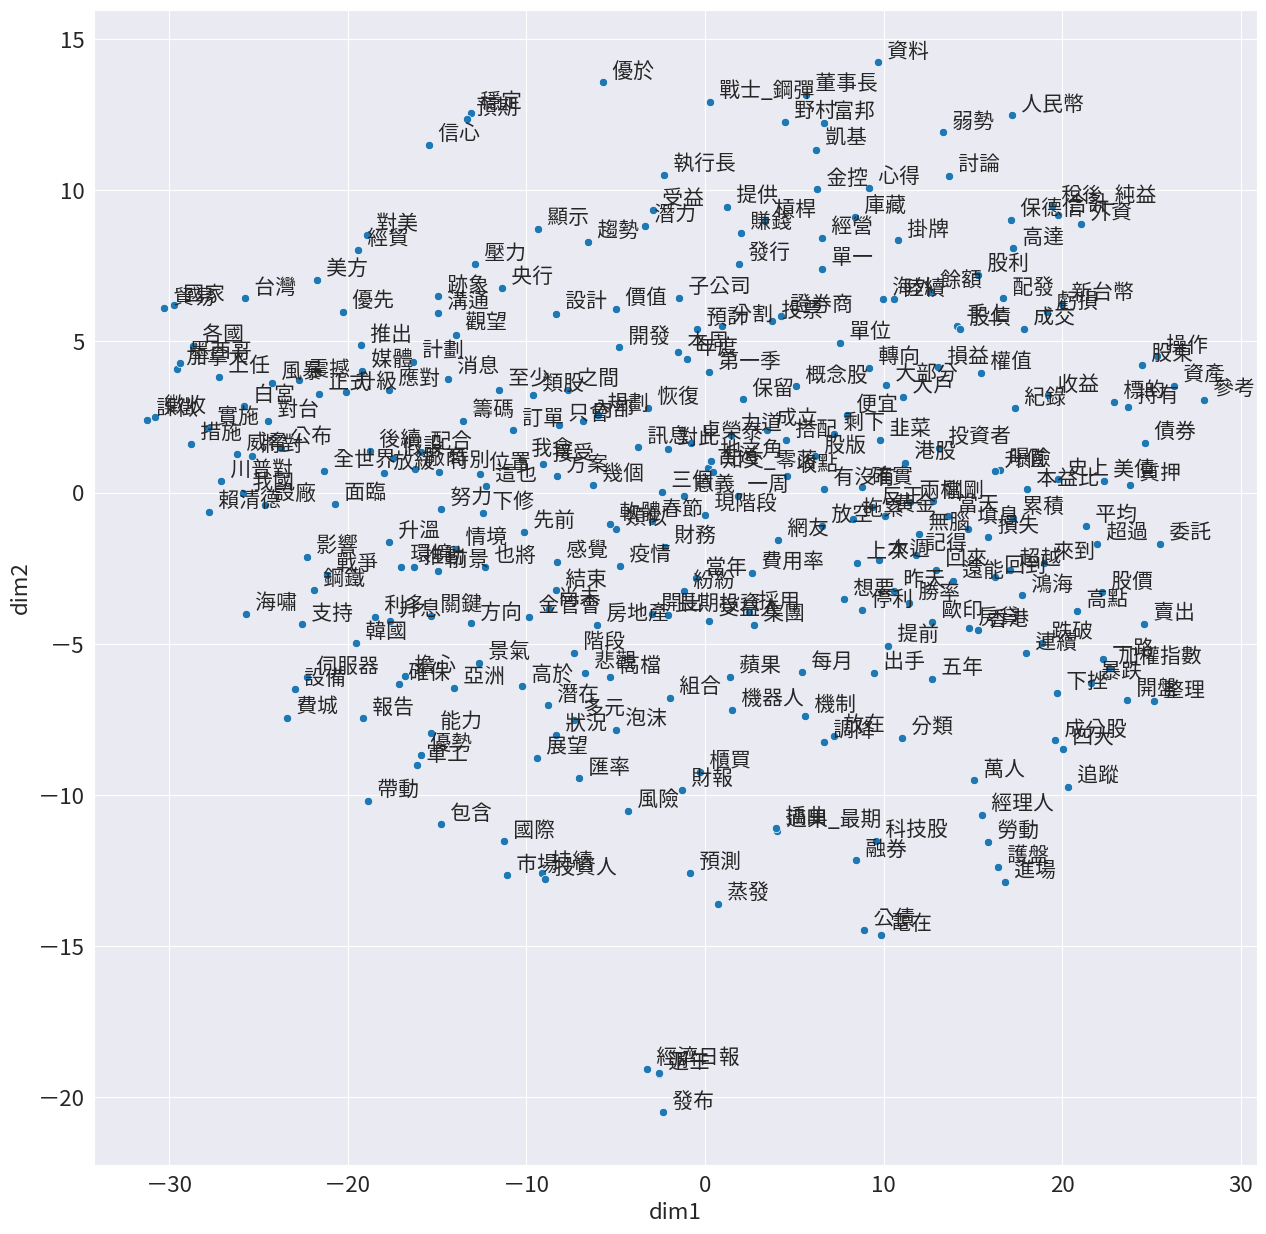

In [26]:
plotScatter(word_df)

## 三維散佈圖
可以觀察到，大多數詞彙集中於圖形中央，表示這些詞在語意上較為接近，可能屬於相同或相關主題範疇（如經濟、政策、金融等）。部分詞彙則位於圖形邊緣或離群位置，例如「心得」、「發布」、「資料」等，顯示其語意上較為獨立，與其他常見主題的關聯性較低。

In [27]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


In [28]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


透過 K-means 分成四個群組。從圖上可以看到，詞彙的分布呈現出幾個聚集的區域，說明模型確實抓到了一些語意上的相似性。像是「利率」、「開盤」、「報酬」、「制度」這類跟金融或政策有關的詞，大多落在同一群；而像「心得」、「發布」、「資料」這些比較通用、用途比較不明確的詞，則出現在邊緣，語意上顯得比較獨立。

In [29]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

In [30]:
from sentence_transformers import SentenceTransformer, models, util

In [31]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('bardsai/finance-sentiment-zh-base')
bert_ch = bert_ch.to('cuda')


bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name bardsai/finance-sentiment-zh-base. Creating a new one with mean pooling.


0

In [32]:
import torch
print(torch.cuda.is_available())  # True 才代表 GPU 可用

True


In [33]:
df_similar = origin_data[['artTitle', 'artContent']]
# 移除 artContent 欄位的 NaN
df_similar = df_similar.dropna(subset=['artContent'])

df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar = df_similar.reset_index(drop=True)
df_similar

artTitle  \
0                     [心得]2024年報   
1               [心得]延畢大學生2024年結算   
2                   [心得]2024小資年報   
3       [新聞]台塑四寶「上兆市值蒸發」套牢87萬股民　   
4     [新聞]0050市值ETF首選？專家3理由喊「風向變   
...                          ...   
1469   [新聞]快訊／00878配0.47元　5／19除息   
1470        [請益]台股要下市是不是難度比上市還高？   
1471      [新聞]謝金河：第一季財報出爐選黑馬川普關稅   
1472     [新聞]台灣維他命是美國的三倍價格！網嘲諷：多   
1473            [請益]請教好用的外匯避險方式？   

                                             artContent  
0     先說結論台股全年已實現損益萬美股年初持倉萬中間入金萬到今天總持倉約萬幣別美金本年初資金約萬台...  
1     跨完年睡不著覺來複盤去年的績效先講概要前半年大盤狂噴的時候沒耐心賣飛好幾隻股票還腦沖當沖了好...  
2     大家好這是第二篇在板上的年報年報皆以當年度為主跨年度歸零計算年報績效不含績效年底資產價值本金...  
3     原文標題台塑四寶上兆市值蒸發套牢萬股民石化慘成水餃股原文連結發布時間記者署名原文內容我是台塑...  
4     原文標題市值首選專家理由喊風向變了績效會說話原文連結發布時間記者署名無原文內容今年可謂是台股...  
...                                                 ...  
1469  原文標題快訊配元除息原文連結發布時間記者署名巫彩蓮原文內容擁有萬股民的國泰永續高股息今日公告...  
1470  明天勞動節沒開市驚奇的月也終於結束大家可以稍微舒緩一下情緒不用這麼緊張閒閒無聊查了一下台灣下...  
1471  謝金河第一季財報出爐選黑馬川普關稅豁免空檔對策年月日文謝金河四月過去了美國是出手的國家股市在...  
1472  股市台股雜談聽新聞台灣維他命是美國的三倍價格網嘲諷多虧川普讓我們看清真相聯合新聞網綜合報導保...  
1473  是這樣的啦小魯在約有鎂的小部位獲利但還不想賣出現在台幣兌美元的匯率還算不錯想直接把匯率鎖在這...  

[1474 rows x 2 columns]

In [34]:
corpus_embeddings = bert_ch.encode(
    df_similar['artContent'],
    convert_to_tensor=True,
    batch_size=32
)

In [35]:
query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [新聞]009272025一月配息0.37元

 資料集中前五相似的文章:
[新聞]009272025一月配息0.37元 (Score: 1.0000)
[新聞]改採DeepSeek?新創公司FigureAI分手OpenA (Score: 0.9554)
[新聞]封關前連3買！外資1月買破10萬張「這檔」 (Score: 0.9528)
[新聞]任天堂成鴻海救世主？Switch2引爆供應鏈 (Score: 0.9519)
[新聞]權值股百花齊放0050重返200元登半年新高 (Score: 0.9483)






In [36]:
metaData

artUrl          artTitle  \
0      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
1      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
2      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
3      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
4      https://www.ptt.cc/bbs/Stock/M.1735671336.A.BD...        [心得]2024年報   
...                                                  ...               ...   
54527  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54528  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54531  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54533  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   
54534  https://www.ptt.cc/bbs/Stock/M.1746028348.A.5B...  [請益]請教好用的外匯避險方式？   

               artDate                                         artContent  \
0       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
1       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
2       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
3       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
4       2025/1/1 02:55  先說結論：\n\n台股2024全年已實現損益1102萬\n美股2024年初持倉25萬  中間...   
...                ...                                                ...   
54527  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54528  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54531  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54533  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   
54534  2025/4/30 23:52  是這樣的啦\n小魯在Firstrade約有12k鎂的小部位獲利，但還不想賣出。\n現在台幣兌...   

                                                sentence  \
0                                                   先說結論   
1      台股全年已實現損益萬美股年初持倉萬中間入金萬到今天總持倉約萬幣別美金本年初資金約萬台幣增加萬...   
2                                         以上不計今年股利約萬獲利來源   
3                                           台股台積電聯發科正二美股   
4                                       暫時還沒賺到錢的標的高股息跟美債   
...                                                  ...   
54527                                        部位賣出後再用美元還款   
54528                                       成本就是這個貨幣對的利差   
54531                 以上是我目前想得到的方法不曉得板上大神都是如何對美元部位進行避險的呢   
54533                                         心情不一樣這倒是真的   
54534                                    美股大風大浪感覺胃口都被養壞了   

                                                    word  \
0                                               [先說, 結論]   
1      [台股, 損益, 萬美股, 年初, 持倉, 入金萬到, 總持倉, 萬幣別, 美金, 年初, ...   
2                                       [不計, 股利, 獲利, 來源]   
3                                 [台股, 台積, 電聯, 發科, 正二美股]   
4                                   [暫時, 沒賺, 標的, 股息, 美債]   
...                                                  ...   
54527                                   [部位, 賣出, 美元, 還款]   
54528                                       [成本, 貨幣, 利差]   
54531                  [想得到, 方法, 曉得, 板上, 大神, 美元, 部位, 避險]   
54533                                       [心情, 這倒, 真的]   
54534                             [美股, 大風大浪, 感覺, 胃口, 養壞]   

                                       word_list_bigrams  
0                                                [先說_結論]  
1      [台股, 損益, 萬美股, 年初, 持倉, 入金萬到, 總持倉, 萬幣別, 美金, 年初, ...  
2                                       [不計, 股利, 獲利, 來源]  
3                                  [台股, 台積, 電聯_發科, 正二美股]  
4                                   [暫時, 沒賺, 標的, 股息, 美債]  
...                                                  ...  
54527                                   [部位, 賣出, 美元, 還款]  
54528                                       [成本, 貨幣, 利差]  
54531                  [想得到, 方法, 曉得, 板上, 大神, 美元, 部位, 避險]  
54533                                       [心情, 這倒, 真的]  
54534                             [美股, 大風大浪, 感覺, 胃口, 養壞]  

[50502 rows x 7 columns]

In [37]:
!pip install sentence_transformers
!pip install ckip_transformers

In [38]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

In [39]:
!pip install bertopic

In [40]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

In [41]:
# 以前50筆資料作為範例
text = metaData['sentence'].tolist()
text = text[:50]

# 初始化 ckip 工具 device=0 使用GPU ｜ device=-1 使用CPU（速度會很慢）
# Mac使用者可以設定 device=torch.device("mps") 使用GPU
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0) # Word Segmenter斷詞
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0) # POS tagger 詞性標記
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0) # NER識別

# 執行處理 
ws = ws_driver(text) # 斷詞
pos = pos_driver(ws) # POS
ner = ner_driver(text) # NER


# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos) # 確認斷詞和POS的長度相同
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})") # 合併在一起
   return "\u3000".join(res) 

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results.head(10)


Inference: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


sentence  \
0                                               先說結論   
1  台股全年已實現損益萬美股年初持倉萬中間入金萬到今天總持倉約萬幣別美金本年初資金約萬台幣增加萬...   
2                                     以上不計今年股利約萬獲利來源   
3                                       台股台積電聯發科正二美股   
4                                   暫時還沒賺到錢的標的高股息跟美債   
5                                               操作方式   
6  階段疫情開始投資股票解儲蓄險全數投入台股最早開始只買台積買過字頭美股當時買只進不出就是台積電...   
7  階段股市回檔以下的台積是上天給你的禮物於是重新建倉均價在這時候還同步買了一些發哥均價左右也買...   
8                 年底空頭結束多頭開啟於是年底到這一年讓我累積到年初的萬本金含房貸增貸   
9       階段加倍開啟質押大法跟房貸增貸擴大投資本金我個人的質押利率是從年初的到目前的所以借好借滿   

                                     packed_sentence  \
0                                  先(D)　說(VE)　結論(Na)   
1  台股(Na)　全(Neqa)　年(Nf)　已(D)　實現(VC)　損益(Na)　萬(Neu)...   
2  以上(Ncd)　不計(VK)　今年(Nd)　股利(Na)　約(Da)　萬(Neu)　獲利(N...   
3              台股(Na)　台積電(Nb)　聯發科(Nb)　正二(Neu)　美股(Na)   
4  暫時(D)　還(D)　沒(D)　賺到(VC)　錢(Na)　的(DE)　標的(Na)　高(VH...   
5                                      操作(Nv)　方式(Na)   
6  階段(Na)　疫情(Na)　開始(VL)　投資(VC)　股票(Na)　解(VC)　儲蓄險(N...   
7  階段(Na)　股市(Nc)　回檔(VH)　以下(Ng)　的(DE)　台積(Nb)　是(SHI...   
8  年底(Nd)　空頭(Na)　結束(VHC)　多頭(Na)　開啟(VC)　於是(Cbb)　年底...   
9  階段(Na)　加倍(D)　開啟(VC)　質押(VD)　大法(Na)　跟(P)　房貸(Na)　...   

                                            entities  
0                                                 []  
1  [NerToken(word='台股', ner='GPE', idx=(0, 2)), N...  
2  [NerToken(word='今年', ner='DATE', idx=(4, 6)), ...  
3  [NerToken(word='台股', ner='NORP', idx=(0, 2)), ...  
4                                                 []  
5                                                 []  
6  [NerToken(word='台股', ner='GPE', idx=(18, 20)),...  
7  [NerToken(word='台積', ner='ORG', idx=(9, 11)), ...  
8  [NerToken(word='年底', ner='DATE', idx=(0, 2)), ...  
9    [NerToken(word='年初', ner='DATE', idx=(31, 33))]

In [42]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "bardsai/finance-sentiment-zh-base"  # 你可以將這裡換成你想要使用的模型
model = pipeline('sentiment-analysis', model=model_name)

# 使用模型來進行情緒分析
text = ["我喜歡這部電影！", "他的行為讓我很困擾"]
result = model(text)

# 輸出結果(標籤和分數)
result


Device set to use cuda:0


[{'label': 'neutral', 'score': 0.9992146492004395},
 {'label': 'negative', 'score': 0.9999295473098755}]

In [ ]:
# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = metaData['sentence']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    result = model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = metaData['sentence'].apply(analyze_sentiment)

# 輸出結果
results_df.head(10)

In [43]:
from umap import UMAP
# 中文文章
docs_zh = metaData['sentence'].tolist()

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("bardsai/finance-sentiment-zh-base",device='cuda')

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立

zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer,verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

No sentence-transformers model found with name bardsai/finance-sentiment-zh-base. Creating a new one with mean pooling.


Batches:   0%|          | 0/1579 [00:00<?, ?it/s]

2025-05-09 11:46:04,376 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-09 11:46:49,869 - BERTopic - Dimensionality - Completed ✓
2025-05-09 11:46:49,872 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-09 11:46:54,761 - BERTopic - Cluster - Completed ✓
2025-05-09 11:46:54,781 - BERTopic - Representation - Fine-tuning topics using representation models.
Building prefix dict from d:\社媒\讀書會3\讀書會3\dict\dict.txt.big ...
Loading model from cache C:\Users\Tak\AppData\Local\Temp\jieba.u4c289f64463bbacf479c5da25d4497dd.cache
Loading model cost 1.354 seconds.
Prefix dict has been built successfully.
2025-05-09 11:47:00,366 - BERTopic - Representation - Completed ✓


Topic  Count                Name  \
0       -1  26618       -1_ _投資_台灣_美國   
1        0   6771       0_重挫_跌幅_下跌_大跌   
2        1   1088       1_發生_意義_兩個_代入   
3        2    641         2_推_記得_說_阿肥   
4        3    473     3_影響_變化_不確定性_情勢   
..     ...    ...                 ...   
422    421     10   421_開心_金採_工作進展_過得   
423    422     10      422_追繳_發出_令_券商   
424    423     10      423_懂_智障_一幫_老套   
425    424     10  424_加權指數_最高峰_再配_化配   
426    425     10   425_存入_配息共次_本次_第次   

                                        Representation  \
0    [ , 投資, 台灣, 美國, 買, 關稅, 元, 中, 川普, 中國, 說, 高, 股, ...   
1    [重挫, 跌幅, 下跌, 大跌, 跌, 跌停, 衝擊, 壓力, 影響, 波動, 虧損, 台股...   
2    [發生, 意義, 兩個, 代入, 這是, 有人, 簡單, 事情, 操作, 文章, 分割, 排...   
3    [推, 記得, 說, 阿肥, 買, 至少, 想, 死, 吃, 樂觀, 仔, 屌, 宣洩, 跪...   
4    [影響, 變化, 不確定性, 情勢, 政策, 政經, 評估, 經濟, 狀況, 走勢, 國際,...   
..                                                 ...   
422  [開心, 金採, 工作進展, 過得, 回籠, 美國財政部, 利, 品質, 各項, 順利, 協...   
423  [追繳, 發出, 令, 券商, 通知, 符, 商還, 已滿, 再拗, 保證金, 正二, 融資...   
424  [懂, 智障, 一幫, 老套, 傻傻的, 發篇文, 難惹, 適用性, 少課, 解方, 一千點...   
425  [加權指數, 最高峰, 再配, 化配, 達點, 元年, 息率, 收點, 加權, 兆, 億, ...   
426  [存入, 配息共次, 本次, 第次, 領取, 初期, 配息元, 大魯閣, 連續, 固定, 首...   

                                   Representative_Docs  
0    [美國總統川普公布各國對等關稅稅率後, 中國更需要台灣, 觀察台股於國安基金宣布進場外資轉為...  
1            [因為無法預期的股價大幅波動, 台股下跌乃國際波動所導致, 川普關稅政策衝擊全球]  
2                       [發標的文未充實內文, 就這麼發生了, 發標的文未充實內文]  
3    [債給我兩分鐘讓我把損益結成冰別融化了眼淚你賺都化了要我怎問哲哲記得你叫我買了吧記得你叫我買...  
4                       [這次受到關稅影響不大, 一定會受到影響, 也都會受到影響]  
..                                                 ...  
422    [過得越來越好, 顯示富邦金採區間操作積極實現資本利得, 他同時透露台美關稅協商工作進展順利]  
423      [券商這二天發出擔保維持追繳令, 券商相繼發出融資追繳令, 各大券商已陸續發出融資追繳令]  
424  [就算也是賺少是啊您為何不發篇文討論一下解方呢, 當然如果假設川普團隊一幫瘋子跟智障那要預測...  
425                           [加權指數達到, 加權指數達到, 加權指數達到]  
426               [包含本次已連續三個月配發元, 表示連續個月都存入, 初期每月固定存入]  

[427 rows x 5 columns]

### 一、最大主題：股市重挫與關稅衝擊
**最顯著的群集編號為 Topic 0，共 6,771 篇文章，主題名稱「重挫_跌幅_下跌_大跌」。**

關鍵字：重挫、跌幅、下跌、大跌、衝擊、關稅、川普、壓力、影響…

核心討論：大部分文章聚焦在台股因國際政經事件（如川普關稅政策）所引發的劇烈波動與市場恐慌。

代表範例：「因為無法預期的股價大幅波動，台股下跌乃國際波動所致，川普關稅政策衝擊全球，投資人嚴陣以待…」

這個最大主題反映了半年內市場對 政策衝擊 與 股價急跌 的高度敏感，是整體財經討論的中心話題。

### 二、中型主題：技術分享、社群互動與不確定性展望
除了主力群集外，有若干規模介於 幾百至一千餘篇 的中型主題，各自代表不同次級議題：

**Topic 1（1,088 篇）– 發生_意義_兩個_代入**
關鍵字：發生、意義、代入、這是、有人、簡單…

主題內容：多為技術分析、教學或心得分享，討論如何將事件或指標「代入」模型，解析走勢意義。

**Topic 2（641 篇）– 推_記得_說_阿肥**
關鍵字*：推、記得、說、阿肥、買、至少…

主題內容：典型 PTT 推文互動，網友在留言串裡喊買喊賣、兄弟互相提醒、用歌曲訴股價下跌的苦。

**Topic 3（473 篇）– 影響_變化_不確定性_情勢**
關鍵字：影響、變化、不確定性、情勢、政策、經濟…

主題內容：關注國際政經與政策走向，如何在不確定環境下評估風險及機會。

這些中型群集既有技術面分享，也有社群互動和政經展望，豐富地反映了 Stock 版討論的多樣面向。

### 三、小型主題：
**討論數少的主題，每個主題僅約 10 篇左右，如「開心_金採_工作進展」、「追繳_發出_券商」、「懂_智障_一幫_老套」…等。**

特點：聚焦極為狹義的小議題，如某個投顧喊單心得、券商融資追繳流程，或幾則深夜閒聊推文。

意義：雖然篇幅少，但呈現社群中五花八門的即時心情與細節，例如：「券商這二天發出擔保維持追繳令，各大券商已陸續通知融資追繳…」

對於想捕捉市場 小趨勢 或 社群情緒 的研究者，這些小主題同樣具有參考價值。

In [44]:
zh_topic_model.visualize_topics()

In [45]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 51/51 [00:18<00:00,  2.73it/s]


這張長條圖展示了第 45 篇文章在所有主題中的機率分佈，其中前三名分別是：

**Topic 138**（去年底_月底_止_年底_惟至） 以約 65 % 的機率佔據絕對主導，代表本文主要在談「年底／月底」這段時間點的市場觀察、回顧或展望。

**Topic 118**（報酬率_年化_總資產_二年_總） 佔約 18 %，顯示作者同時觸及投資績效、年化報酬與資產配置的討論。

**Topic 10**（質押_信貸_賣出_買股_賣掉） 佔約 14 %，暗示文中也提到了質押、信貸或融資操作等實務面議題。

由此可見，這篇文章以「年底行情展望」為核心主題，並輔以「年化報酬」與「證券信貸」兩個次要話題，呈現出多層次且相互交織的內容結構。

In [46]:
# 以第18個文件為例，列出這份文件對每個主題的機率分布
zh_topic_model.visualize_distribution(topic_distr[45])

In [47]:
# 列出主題的代表詞和其對應的權重
zh_topic_model.get_topic(2)

[('推', 0.011028721742687925),
 ('記得', 0.006436314981208743),
 ('說', 0.006103314032310864),
 ('阿肥', 0.005986578509462504),
 ('買', 0.005950160678110485),
 ('至少', 0.005885105662973481),
 ('想', 0.005631555819080346),
 ('死', 0.005451642926949555),
 ('吃', 0.00525905725742252),
 ('樂觀', 0.0048276562949795526),
 ('仔', 0.00476784295177853),
 ('屌', 0.004423257773325272),
 ('宣洩', 0.004423257773325272),
 ('跪', 0.004342592343905187),
 ('老神在在', 0.004299691059363855),
 ('無腦', 0.004173863958428957),
 ('真的', 0.004127393926031892),
 ('捏', 0.004040328990382778),
 ('賺', 0.003992527651468983),
 ('傻', 0.003934382599596215),
 ('還在', 0.00391597528539434),
 ('惹', 0.0038927880122834146),
 ('優待', 0.003802071686474579),
 ('瘋狂', 0.0037812686526411624),
 ('聽', 0.0037176980559729344),
 ('早上', 0.0036969199436375265),
 ('甘會', 0.003695284962685199),
 ('想要', 0.003634647900482805),
 ('跑', 0.003615952924357972),
 ('抱', 0.003589092651978528)]

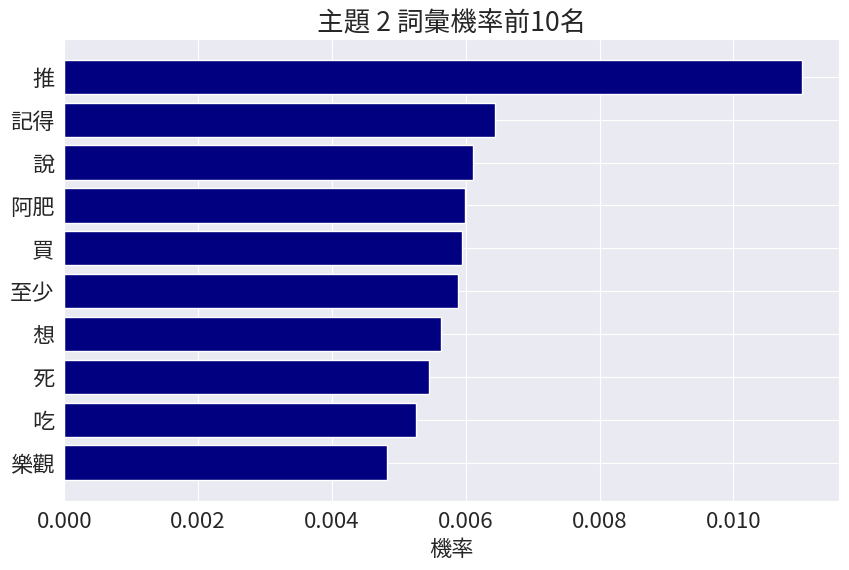

In [48]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

In [49]:
from bertopic.representation import KeyBERTInspired
# KeyBERT
keybert = KeyBERTInspired()

# 設定HDBscan模型
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# 定義我們要用到的representation model（同學如果想比較其他模型可以在這邊加入其他模型方法）
representation_model = {
    "KeyBERT": keybert,
}

In [50]:
# 建立BERTopic模型
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,
  vectorizer_model=jieba_vectorizer,
  # 設定Representation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-09 11:47:31,519 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-09 11:47:49,921 - BERTopic - Dimensionality - Completed ✓
2025-05-09 11:47:49,924 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-09 11:47:53,422 - BERTopic - Cluster - Completed ✓
2025-05-09 11:47:53,437 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-09 11:48:12,398 - BERTopic - Representation - Completed ✓


In [51]:
# 觀察KeyBERT微調後的主題表示
representation_topic_model.get_topic_info()

Topic  Count              Name  \
0       -1  30010     -1_ _美國_台灣_台股   
1        0    749     0_兩個_改變_這是_代入   
2        1    738         1_推_幹_買_說   
3        2    690      2_上漲_讚_點或_高點   
4        3    628     3_大跌_衝擊_影響_失守   
..     ...    ...               ...   
468    467     10  467_日均_成交量_約_達兆元   
469    468     10   468_被扣_扣_買聯電_找錯   
470    469     10    469_碼_火星_損多_股號   
471    470     10  470_萬人_周增_戶元_應用面   
472    471     10  471_巴不得_連他_制冷_損耗   

                                        Representation  \
0    [ , 美國, 台灣, 台股, 關稅, 指數, 市場, 投資, 中, 川普, 股市, 買, ...   
1    [兩個, 改變, 這是, 代入, 發生, 文未, 發標, 意義, 很長, 事情, 原因, 充...   
2    [推, 幹, 買, 說, 至少, 吃, 記得, 跪, 喔, 無腦, 死, 賺, 嘴, 想, ...   
3    [上漲, 讚, 點或, 高點, 高, 買進, 漲點, 股息, 重申, 看好, 買入, 買超,...   
4    [大跌, 衝擊, 影響, 失守, 跌, 公公, 回元, 下跌, 重挫, 股神, 震盪, 金融...   
..                                                 ...   
468  [日均, 成交量, 約, 達兆元, 已達, 年減, 總成交, 大減, 市場, 創, 累計, ...   
469  [被扣, 扣, 買聯電, 找錯, 幸災樂禍, 國庫券, 喊來, 南下, 算錯, 悲觀, 內地...   
470  [碼, 火星, 損多, 股號, 股名, 格式, 不停, 刪除, 標的, 特斯拉, 馬斯克, ...   
471  [萬人, 周增, 戶元, 應用面, 小股民, 就業人口, 資金來源, 指教, 設廠, 贊成,...   
472  [巴不得, 連他, 制冷, 損耗, 受傷害, 價碼, 掃墓, 眼睜睜, 發熱, 摩擦, 還買...   

                                           KeyBERT  \
0         [措施, 股市, 大盤, 股價, 中國, 全球, 台灣, 操作, 政策, 美國]   
1    [單獨, 整理, 有沒有, 排除, 分拆, 基本面, 一段時間, 發生, 細節, 有三大]   
2        [債呼, 這摸, 甘會, 他媽, 還在, 債給, 當腦衝, 隨便, 多買, 輸給]   
3         [升值, 上漲, 復甦, 買進, 穩定, 看好, 買入, 優於, 成功, 齊漲]   
4    [失守, 跌逾點, 不利, 難看, 困難, 哀鴻遍野, 重挫, 金融危機, 股災, 跌停]   
..                                             ...   
468       [總成交, 台股, 日均, 金額, 成交量, 已達, 時, 創, 今日, 收盤]   
469     [錢給, 黑天鵝, 今晚, 國庫券, 沒來, 送到, 指數, 店員, 湧入, 報酬]   
470     [指數, 格式, 持續性, 不停, 財報, 長期, 亮點, 不在乎, 題材, 取消]   
471     [增加, 拓展, 提高, 周增, 加大, 赴美, 國安, 受益人, 台積電, 萬人]   
472       [只能, 價位, 駕駛, 報價, 盤勢, 花費, 摩擦, 類別, 新車, 額外]   

                                   Representative_Docs  
0    [採行調整每日盤中借券賣出委託數量最低融券保證金成數及放寬擔保品範圍等項穩定股市的暫行措施,...  
1                    [但是一天要操作兩個, 發標的文未充實內文, 發標的文未充實內文]  
2    [但是會讓你晚年有飯吃推針對第一點所以指數派才有那種傳統伯格頭三分法或推沒有必勝的方法你找指...  
3    [指數上漲點, 保德信市值動能透過國際專業金融分析機構對於企業未來個月成長率展望納入評比, ...  
4    [不去想台股今天又跌了幾我看見五日的均線向下沒變化我知道我一直有雙隱形的翅膀帶我飛給我希望我...  
..                                                 ...  
468         [台股集中市場日均成交量約, 台股集中市場日均成交量約, 台股集中市場日均成交量約]  
469  [要是黑天鵝沒來不就錯過股市的報酬下圖引用自投資金律可以看到最安全的短期國庫券, 算錯無所謂...  
470  [標題請使用以下格式股號市場碼股名分類市場碼標的台積電長期不停損多標的特斯拉馬斯克火星多按可...  
471                 [小股民卻增加萬人, 非農就業人口增加萬人, 檔台股受益人周增萬人]  
472  [還買了摩擦損耗的正, 不必再因為延遲報價需確認盤勢價位而花費額外時間心力, 老黃終於來了最...  

[473 rows x 6 columns]

主題模型分析總結（川普上任後對社群股票言論的影響）

* Topic -1：雜項或未明確分類
  * 多涉及「報酬率」、「大幅度波動」、「機會成本」、「投資人心理」
  * 這可能是川普政策（如減稅、經濟刺激）導致資金寬鬆，引發台灣民眾以信貸進場炒股的風潮，反映在社群討論中。

* Topic 0：美債與資產配置
  * 討論資產配置、美債與股票的相對優劣
  * 討論「美債是否值得買」、「股票回報 vs 債券」、「疫情後投資策略轉變」
  * 川普政府期間的低利率政策與美債殖利率波動，讓社群關注是否要從股票轉向債券。

* Topic 1：本金與獲利
  * 計算獲利績效、回顧年度資產表現
  * 提到「怎麼計算報酬率」、「含股息的總績效」、「信貸金額帶來的獲利或虧損」
  * 川普任期造成資產劇烈波動（尤其是2020 COVID-19），社群重視資產成長性與風險控管。

* Topic 3：台塑四寶與大股東
  * 提到台塑四寶的股價、市值、對散戶的吸引力
  * 政策如對中國的貿易戰影響石化業出口與投資情緒，可能影響對台塑等企業的看法。

* Topic 5：產能與乙烯產業
  * 分析中國乙烯產能增加可能造成台灣出口壓力
  * 川普對中政策加劇中美產業分流，影響台灣石化相關產業信心與討論熱度。

* Topic 6：半導體投資
  * 討論「受益權」、「ETF 指數追蹤」、「成分股表現」
  * 中美科技戰推升台灣半導體戰略地位，川普政府強硬立場讓社群更看好半導體股票。

### 結論：社群反應川普政策對投資情緒的幾個面向

* 金融資金流	寬鬆資金政策刺激投資人進場（信貸炒股、報酬率比較）
* 資產配置選擇	美債 vs 股票的討論熱度提升
* 中美產業分流	對半導體、石化產業的關注與分析加劇
* 波動與風險	討論集中在獲利計算、資產保值、年終回顧等